In [1]:
import qiskit
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, execute, IBMQ
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, pauli_error, ReadoutError
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import hellinger_distance

### 2 qubit random walk (4 nodes)
coin operator = H ----- coin state = '|0>' or '|1>'
Shift Operator = Incremental circuit or decremental circuit

Case 1:
If coin state = |1>, the random walker moves one step to left(say):
00 --> 11;
11 --> 10;
10 --> 01;
01 --> 00;

Case 2:
If coin state = |0>, the random walker moves one step to right(say):
00 --> 01;
01 --> 10;
10 --> 11;
11 --> 00;

Repeat Shift Operator, n more times for n+1 steps taken by random walker

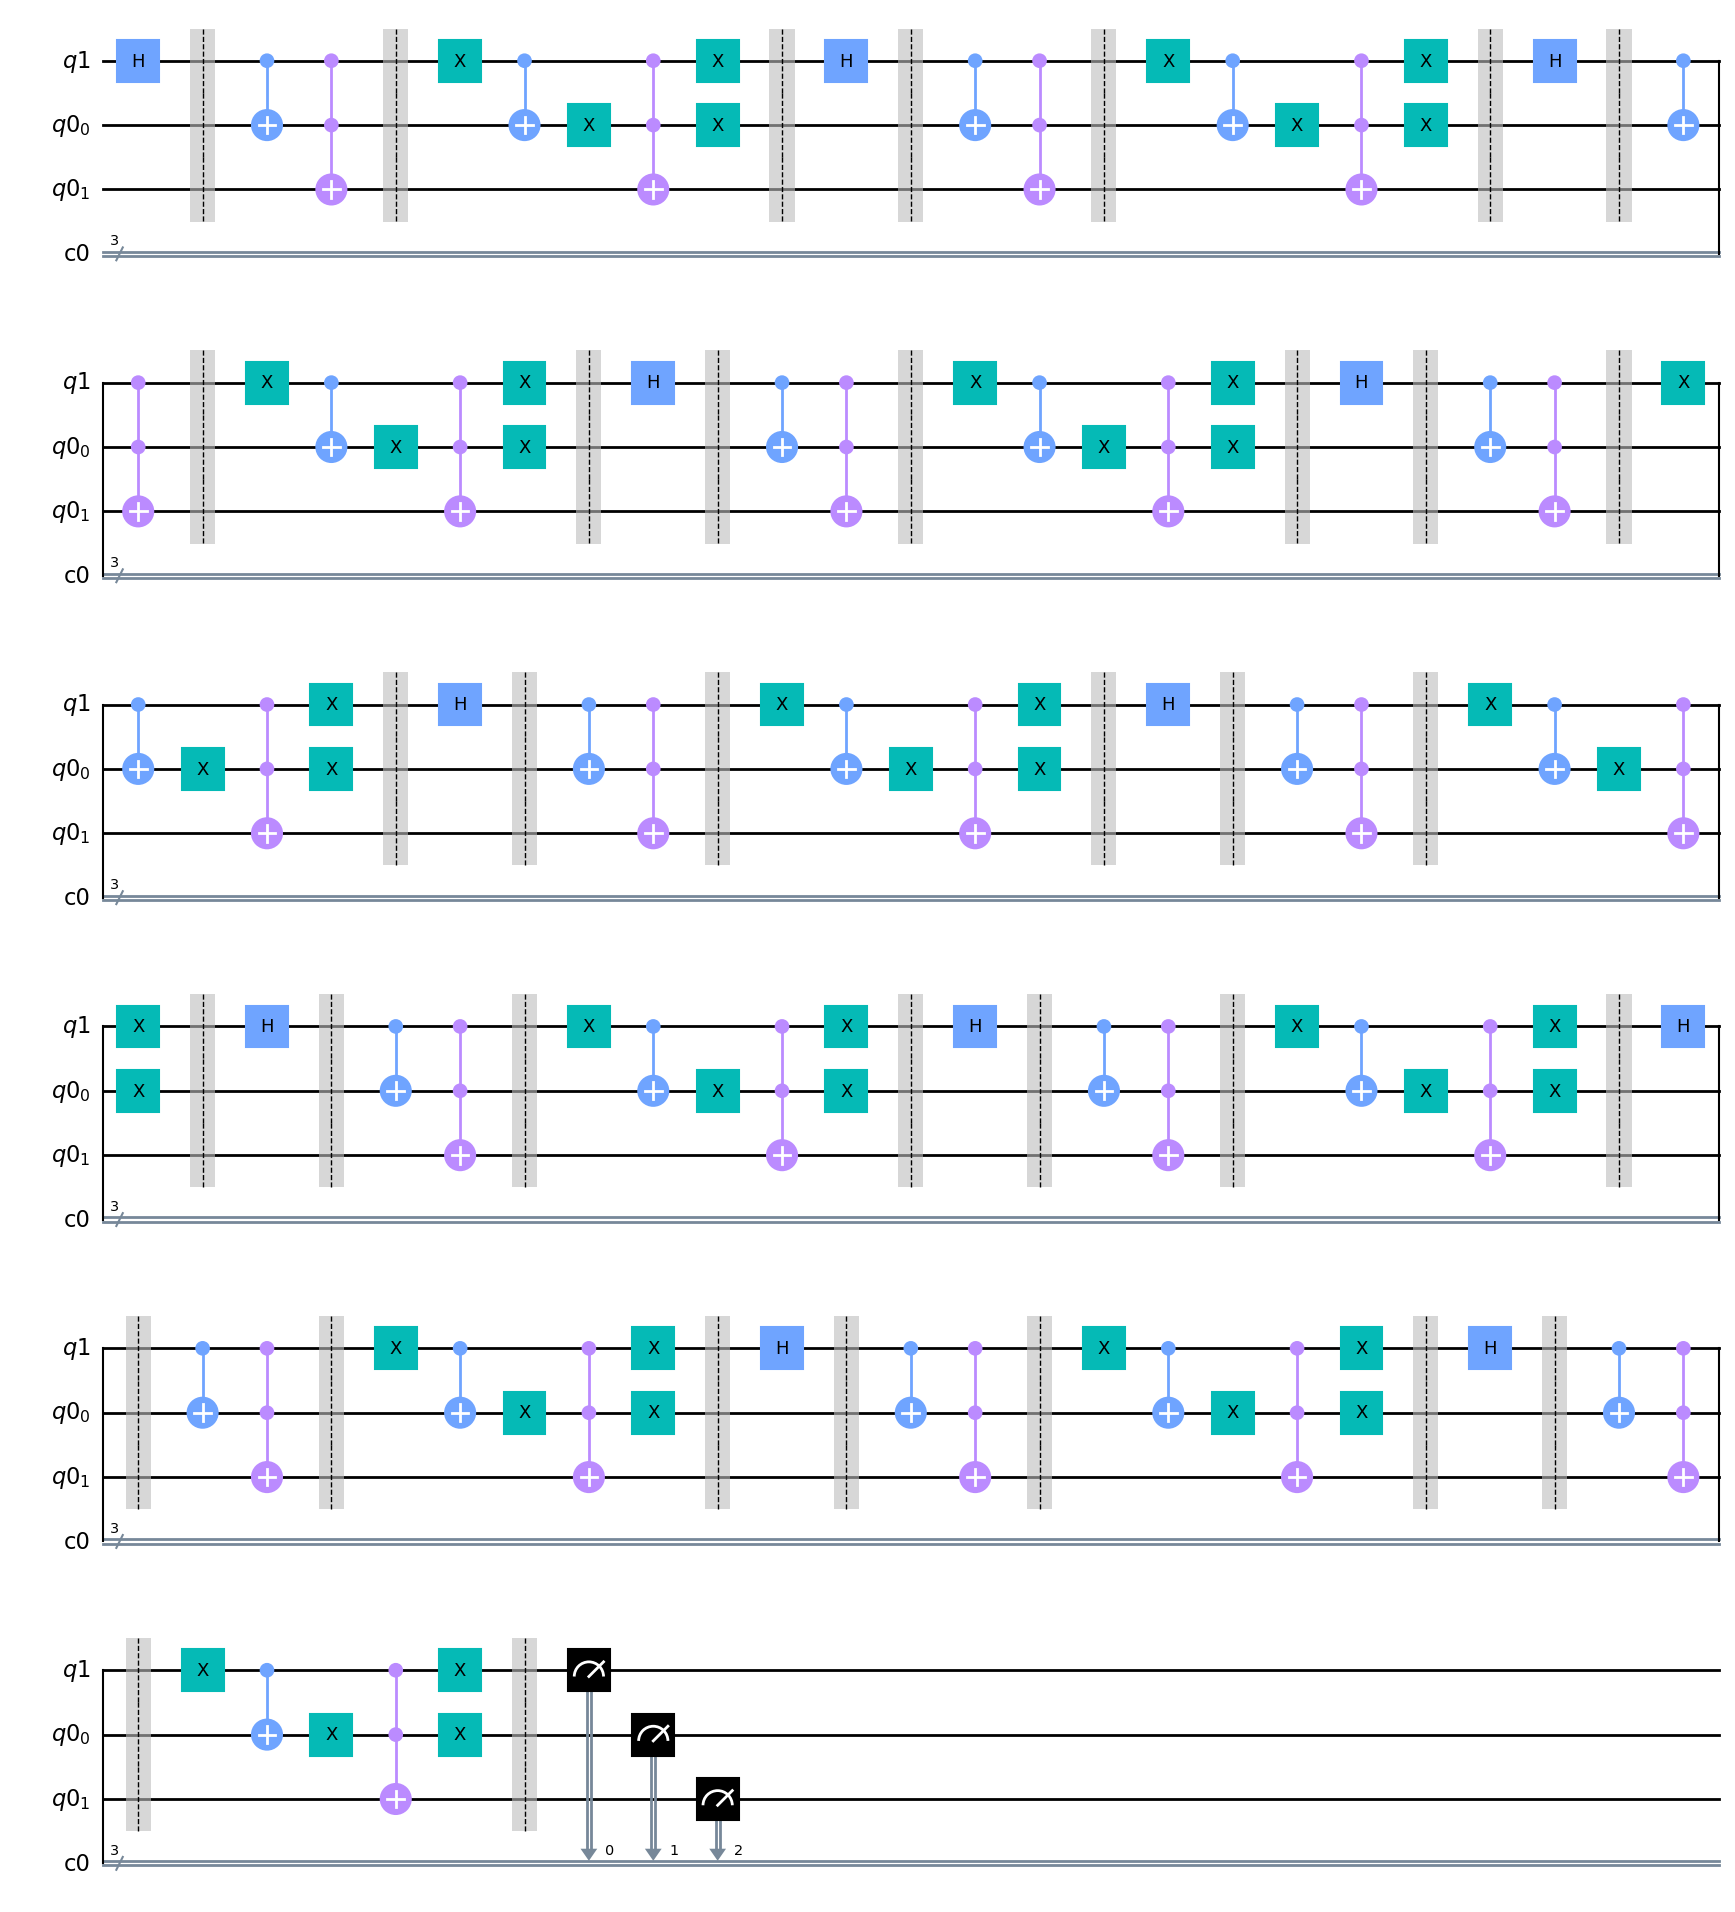

In [2]:
p = QuantumRegister(2)      #Position state
c = QuantumRegister(1)      #Coin state
cr = ClassicalRegister(3)
qw = QuantumCircuit(c,p,cr)
steps = 12
for i in range(steps):
    #Step 1: Say random walker starts from '00' state and initiate the coin operator
    qw.h(c[0])
    qw.barrier()    
    #Step 2: Implement a shift operator for case 1
    qw.cx(c[0],p[0])
    qw.ccx(c[0],p[0],p[1])
    qw.barrier()
    #Step 3: Implement a shift operator for case 2
    qw.x(c[0])
    qw.cx(c[0],p[0])
    qw.x(p[0])
    qw.ccx(c[0],p[0],p[1])
    qw.x(p[0])
    qw.x(c[0])
    qw.barrier()
qw.measure([c[0],p[0],p[1]],[cr[0],cr[1],cr[2]])
qw.draw('mpl')

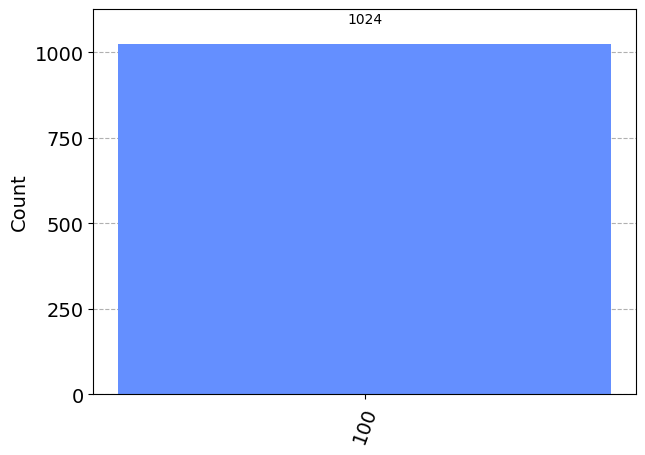

In [3]:
job = execute(qw, Aer.get_backend('qasm_simulator'))
counts = job.result().get_counts()
plot_histogram(counts)

### Custom defined Noise model

In [4]:
noisemodel = NoiseModel()

#Depolarizing error
p_error = 0.1
oneq_dn = depolarizing_error(p_error,1)
twoq_dn = depolarizing_error(p_error,2)

#Pauli error (bit and phase flip)
p_reset = 0.1
p_meas = 0.1
p_gate1 = 0.1
error_reset = pauli_error([('Y', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('Y',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('Y',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
error_gate3 = error_gate1.tensor(error_gate2)

#thermal and relaxation error
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= 2*T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(3)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_h  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_x  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
#errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              #for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

#Add errors to noise model
#Let basis be 'u1','u2','u3','cx'
noisemodel.add_all_qubit_quantum_error(oneq_dn,['h','x'])
noisemodel.add_all_qubit_quantum_error(twoq_dn,['cx'])

#noisemodel.add_readout_error(readout_error,['c[0]'])
#noisemodel.add_readout_error(readout_error,['p[0]'])
#noisemodel.add_readout_error(readout_error,['p[1]'])

noisemodel.add_all_qubit_quantum_error(error_reset, "reset")
noisemodel.add_all_qubit_quantum_error(error_meas, "measure")
noisemodel.add_all_qubit_quantum_error(error_gate1, ["h", "x"])
noisemodel.add_all_qubit_quantum_error(error_gate2, ["cx"])
noisemodel.add_all_qubit_quantum_error(error_gate3, ["ccx"])

#adding thermal noise
for j in range(3):
    noisemodel.add_quantum_error(errors_reset[j], "reset", [j])
    noisemodel.add_quantum_error(errors_measure[j], "measure", [j])
    noisemodel.add_quantum_error(errors_h[j], "h", [j])
    noisemodel.add_quantum_error(errors_x[j], "x", [j])
    #noisemodel.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(3):
        noisemodel.add_quantum_error(errors_cx[j][k], "cx", [j, k])
print(noisemodel)

NoiseModel:
  Basis gates: ['ccx', 'cx', 'h', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'measure', 'x', 'reset', 'h', 'ccx']
  Qubits with noise: [0, 1, 2]
  All-qubits errors: ['h', 'x', 'cx', 'reset', 'measure', 'ccx']
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2))]


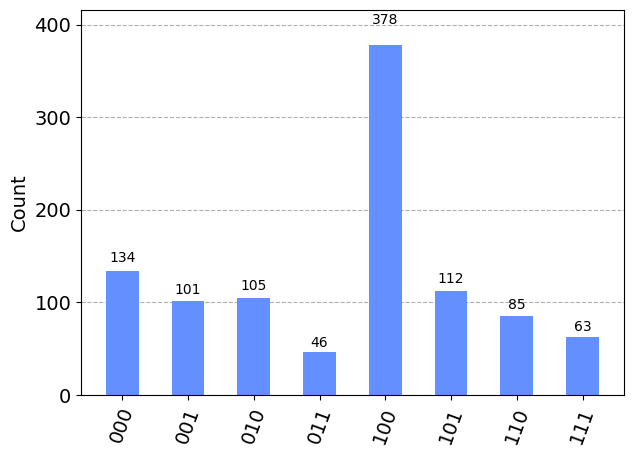

In [5]:
noisy_sim = AerSimulator(noise_model = noisemodel)
t_circ = transpile(qw,noisy_sim,basis_gates=['cx','id','rz','sx','x'])
noisy_counts = noisy_sim.run(t_circ).result().get_counts()
plot_histogram(noisy_counts)

In [6]:
#Finding Hellinger Distance
hd = hellinger_distance(counts,noisy_counts)
print(hd)

0.6264427823227458


### Noise Model from backend ibm_nairobi

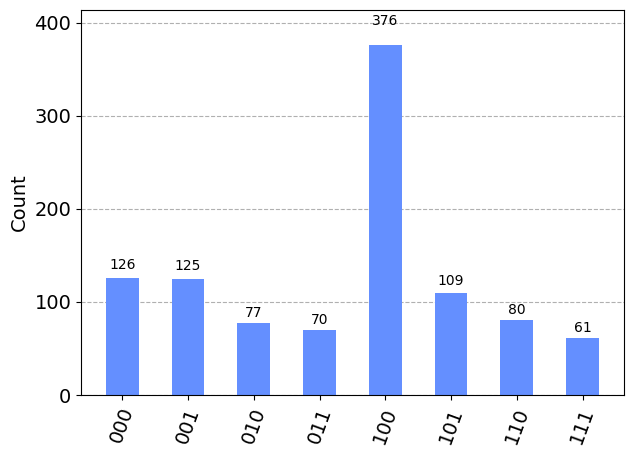

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService

#QiskitRuntimeService.save_account(channel="ibm_quantum", token="84e47768480771b0f65f16b3f25447e5ab6b88d174cccb8271d1d0a3e4fdf3ce875e7f9f2612ad64f6f107644f49d8c6d9cd2619469de103753b4ae7556e703a")
service = QiskitRuntimeService()
backend_nairobi = service.backend("ibm_nairobi")
backend_noisemodel = NoiseModel.from_backend(backend_nairobi)

basis_gates = backend_noisemodel.basis_gates
bnoisy_sim = AerSimulator(noise_model=backend_noisemodel,basis_gates=basis_gates)
bt_circ = transpile(qw,bnoisy_sim)
bnoisy_counts = bnoisy_sim.run(bt_circ).result().get_counts()
plot_histogram(bnoisy_counts)

In [8]:
b_hd = hellinger_distance(counts,bnoisy_counts)
print('Hellinger distance value for counts from qasm simulator and from noisy backend ibm nairobi is {}'.format(b_hd))
print('Hellinger distance value for counts from qasm simulator and from custom noisy backend is {}'.format(hd))

Hellinger distance value for counts from qasm simulator and from noisy backend ibm nairobi is 0.6277260690961932
Hellinger distance value for counts from qasm simulator and from custom noisy backend is 0.6264427823227458
